## Part II: Optimizing NN

In [1]:
# Import libraries
import pandas as pd
import numpy as np

In [2]:
# Load preprocessed data
preprocessed_df = pd.read_csv('dataset_preprocessed.csv')

In [3]:
preprocessed_df.head()

,f1,f2,f3,f4,f5,f6,f7,target
0,6,148,72,35,0,33.6,0.627,1
1,1,85,66,29,0,26.6,0.351,0
2,8,183,64,0,0,23.3,0.672,1
3,1,89,66,23,94,28.1,0.167,0
4,0,137,40,35,168,43.1,2.288,1


In [4]:
# Split data to X i.e. feature by dropping columns which has correlation close to 0 with target and target
X = preprocessed_df.drop(columns=['f3', 'f4','target'])
# Split data to y i.e. target 
y = preprocessed_df['target']

In [5]:
# Scale the input features
from sklearn.preprocessing import StandardScaler

# Initialize StandardScalar
scaler = StandardScaler()
# Scale the values of features
X_scaled = scaler.fit_transform(X)

In [6]:
# Split data in training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=42)

In [7]:
# Split the training data in training and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [8]:
from sklearn.utils.class_weight import compute_class_weight
import torch

# For improving the nn_model assigning higher weights to minor class
target_class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights = torch.tensor(target_class_weights, dtype=torch.float32)

In [9]:
# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

In [10]:
# Create DataLoader and TensorDataset for shuffling and batching data
from torch.utils.data import DataLoader, TensorDataset

# Create DataLoader and TensorDataset for shuffling and batching data
from torch.utils.data import DataLoader, TensorDataset

train_tensor_data = TensorDataset(X_train_tensor, y_train_tensor)
val_tensor_data = TensorDataset(X_val_tensor, y_val_tensor)
test_tensor_data = TensorDataset(X_test_tensor, y_test_tensor)

train_data_loader = DataLoader(train_tensor_data, batch_size=32, shuffle=True)
val_data_loader = DataLoader(val_tensor_data, batch_size=32, shuffle=False)
test_data_loader = DataLoader(test_tensor_data, batch_size=32, shuffle=False)

#### 1. Choose one hyperparameter to modify (e.g., Dropout). Fix the NN structure andvall other parameters based on the model defined in Part I and change valuesvonly for your chosen hyperparameter. 

#### 2. Choose another hyperparameter and go to Step 1. Do the same procedure for three hyperparameters.

In [11]:
import torch.nn as nn
import torch.optim as optim

In [12]:
# We have taken the neural network from Part I as base model and will train this model for different p values for dropout
class NNBinaryClassification_Dropout(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(NNBinaryClassification_Dropout, self).__init__()
        self.fc1 = nn.Linear(5, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 64)
        self.relu2 = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [13]:
# p values for dropout tuning
dropout_configs = [0.2, 0.4, 0.7]

In [14]:
# We have taken the neural network from Part I as base model and will train this model for different hidden layer sizes
class NNBinaryClassification_HiddenLayerSize(nn.Module):
    def __init__(self, hidden_layer_size=64):
        super(NNBinaryClassification_HiddenLayerSize, self).__init__()
        self.fc1 = nn.Linear(5, hidden_layer_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.relu2 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(hidden_layer_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [15]:
# Hidden layer size configurations
hidden_layer_size_configs = [32, 60, 128]

In [16]:
# We have taken the neural network from Part I as base model and will train this model for different learning rates for SGD Optimizer
class NNBinaryClassification_SGDOptimizer(nn.Module):
    def __init__(self):
        super(NNBinaryClassification_SGDOptimizer, self).__init__()
        self.fc1 = nn.Linear(5, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 64)
        self.relu2 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [34]:
# learning rate configurations for SGD Optimizer
learning_rates = [0.001, 0.02, 0.0099]

In [18]:
# Function to create model with the tuned parameter
def create_model_variation(param_type, config_param):
    if param_type == 'dropout':
        return NNBinaryClassification_Dropout(dropout_rate=config_param)
    elif param_type == 'layer_size':
        return NNBinaryClassification_HiddenLayerSize(hidden_layer_size=config_param)
    elif param_type == 'optimizer':
        nn_model = NNBinaryClassification_SGDOptimizer()
        optimizer = optim.SGD(nn_model.parameters(), lr=config_param, momentum=0.9)
        return nn_model, optimizer

In [19]:
# Method to evaluate model
def evaluate_model(nn_model, data_loader, loss_function):
    nn_model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, targets in data_loader:
            outputs = nn_model(data)
            loss = loss_function(outputs, targets)
            
            predicted = torch.round(outputs)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            total_loss += loss.item()
    
    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [20]:
# Method for training model
def train_model(nn_model, optimizer, train_loader, val_loader=None, epochs=20):
    loss_function = nn.BCEWithLogitsLoss(pos_weight=weights[1])
    model_statistics = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(epochs):
        nn_model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for i, (data, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = nn_model(data)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            predicted = torch.round(outputs)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            train_loss += loss.item()
        
        # Calculate epoch statistics
        epoch_loss = train_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        model_statistics['train_loss'].append(epoch_loss)
        model_statistics['train_acc'].append(epoch_acc)
        
        # Evaluating model using validation data
        if val_loader is not None:
            val_loss, val_acc = evaluate_model(nn_model, val_loader, loss_function)
            model_statistics['val_loss'].append(val_loss)
            model_statistics['val_acc'].append(val_acc)
    
    return model_statistics

In [21]:
# Evaluating the performance of test data
from sklearn.metrics import precision_recall_fscore_support
from torchmetrics import Accuracy

def test_accuracy(nn_model):
# Initialize empty lists for true and predicted values
    y_true = []
    y_pred = []
    # Initialize accuracy for binary classification
    accuracy_metric = Accuracy(task='binary')

    loss_function = nn.BCEWithLogitsLoss(pos_weight=weights[1])

    test_running_loss = 0.0

    nn_model.eval()

    with torch.no_grad(): 
        for inputs, labels in test_data_loader:
            outputs = nn_model(inputs)

            loss = loss_function(outputs, labels.view(-1, 1))

            # Calculate test loss
            test_running_loss += loss.item()

            predicted = torch.round(outputs)

            accuracy_metric.update(predicted, labels.view(-1, 1))

            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())


    # Calculate accuracy
    test_accuracy = accuracy_metric.compute().item()
    print(f'Test Accuracy: {test_accuracy* 100:.2f}%')

    return test_accuracy* 100

In [22]:
# Method to try various hyperparameters and their setups
def get_test_results():
    results = {}
    loss_function = nn.BCEWithLogitsLoss(pos_weight=weights[1])
    
    # Test dropout configurations
    test_dropout = {'': ['Setup #1', 'Setup #2', 'Setup #3'], 'Value': [], 'Test Accuracy': []}
    dropout_statistics = []
    print('Hyperparameter: Dropout')
    for d in dropout_configs:
        nn_model = NNBinaryClassification_Dropout(dropout_rate=d)
        optimizer = optim.SGD(nn_model.parameters(), lr=0.01, momentum=0.9)
        dropout_model_statistics = train_model(nn_model, optimizer, train_data_loader)
        accuracy = evaluate_model(nn_model, test_data_loader, loss_function)[1]
        results[f'dropout_{d}'] = {
            'accuracy': accuracy,
            'type': 'dropout',
            'value': d,
            'model': nn_model
        }
        test_dropout['Value'].append(d)
        test_dropout['Test Accuracy'].append(accuracy)
        dropout_statistics.append(dropout_model_statistics)
    
    dropout_results = pd.DataFrame.from_dict(test_dropout)
    print(dropout_results)

    print()
    
    # Test hidden layer size configurations
    test_hidden_layer_size = {'': ['Setup #1', 'Setup #2', 'Setup #3'], 'Value': [], 'Test Accuracy': []}
    hidden_layer_size_statistics = []
    print('Hyperparameter: Hidden Layer size')
    for h in hidden_layer_size_configs:
        nn_model = NNBinaryClassification_HiddenLayerSize(hidden_layer_size=h)
        optimizer = optim.SGD(nn_model.parameters(), lr=0.01, momentum=0.9)
        hidden_layer_model_statistics = train_model(nn_model, optimizer, train_data_loader)
        accuracy = evaluate_model(nn_model, test_data_loader, loss_function)[1]
        results[f'hidden_{h}'] = {
            'accuracy': accuracy,
            'type': 'hidden_layer',
            'value': h,
            'model': nn_model
        }
        test_hidden_layer_size['Value'].append(h)
        test_hidden_layer_size['Test Accuracy'].append(accuracy)
        hidden_layer_size_statistics.append(hidden_layer_model_statistics)
    
    hidden_layer_size_results = pd.DataFrame.from_dict(test_hidden_layer_size)
    print(hidden_layer_size_results)

    print()
    
    # Test learning rate configurations
    test_learning_rate = {'': ['Setup #1', 'Setup #2', 'Setup #3'], 'Value': [], 'Test Accuracy': []}
    learning_rate_statistics = []
    print('Hyperparameter: Learning Rate')
    for lr in learning_rates:
        nn_model, optimizer = create_model_variation('optimizer', lr)
        learning_rate_model_statistics = train_model(nn_model, optimizer, train_data_loader)
        accuracy = evaluate_model(nn_model, test_data_loader, loss_function)[1]
        results[f'lr_{lr}'] = {
            'accuracy': accuracy,
            'type': 'learning_rate',
            'value': lr,
            'model': nn_model
        }
        test_learning_rate['Value'].append(lr)
        test_learning_rate['Test Accuracy'].append(accuracy)
        learning_rate_statistics.append(learning_rate_model_statistics)
    
    learning_rate_result = pd.DataFrame.from_dict(test_learning_rate)
    print(learning_rate_result)

    return results, dropout_statistics, hidden_layer_size_statistics, learning_rate_statistics

In [37]:
test_results, dropout_statistics, hidden_layer_size_statistics, learning_rate_statistics = get_test_results()

Hyperparameter: Dropout
             Value  Test Accuracy
0  Setup #1    0.2      74.782609
1  Setup #2    0.4      73.043478
2  Setup #3    0.7      75.652174

Hyperparameter: Hidden Layer size
             Value  Test Accuracy
0  Setup #1     32      72.173913
1  Setup #2     60      75.652174
2  Setup #3    128      74.782609

Hyperparameter: Learning Rate
              Value  Test Accuracy
0  Setup #1  0.0010      64.347826
1  Setup #2  0.0200      73.043478
2  Setup #3  0.0099      77.391304


In [ ]:
import matplotlib.pyplot as plt

def plot_training_progress(statistics, param_type, param_values):
    plt.figure(figsize=(12, 6))

    # plot train accuracy
    plt.subplot(1, 2, 1)
    for idx, param_value in enumerate(param_values):
        plt.plot(statistics[idx]['train_acc'], label=f'{param_type} = {param_value}')
    plt.title(f'Train Accuracy for {param_type}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    # train loss
    plt.subplot(1, 2, 2)
    for idx, param_value in enumerate(param_values):
        plt.plot(statistics[idx]['train_loss'], label=f'{param_type} = {param_value}')
    plt.title(f'Train Loss for {param_type}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

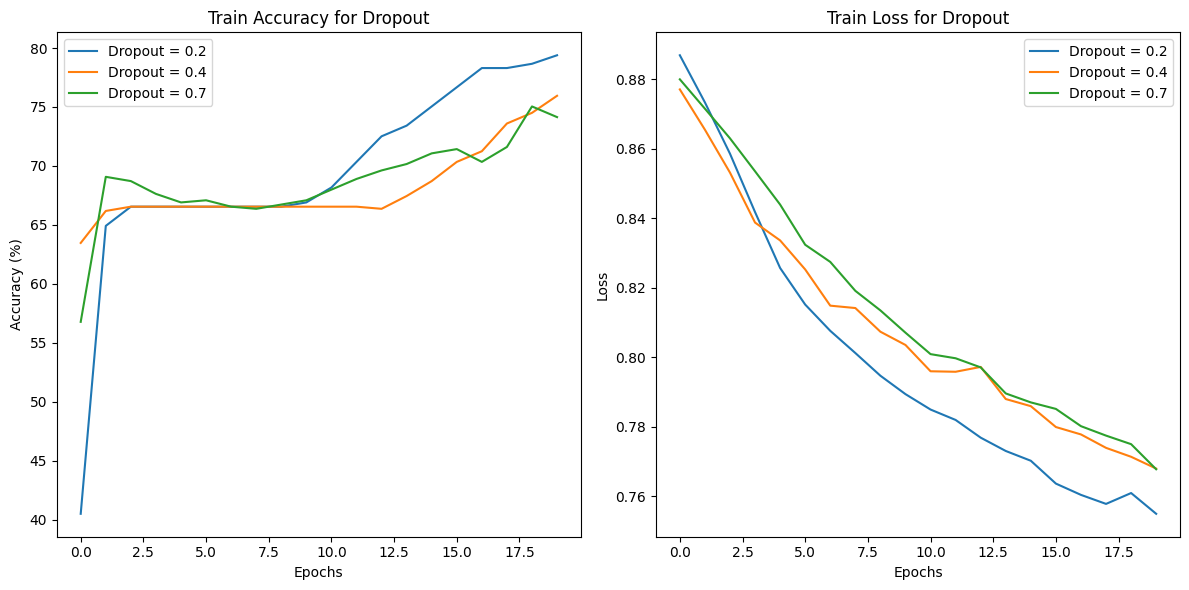

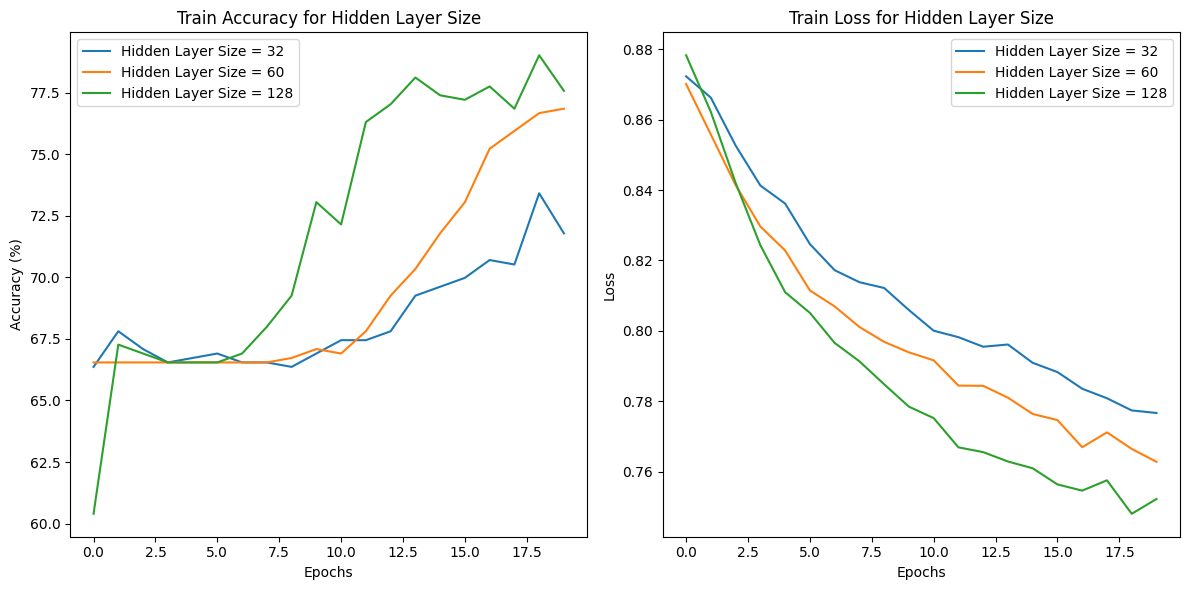

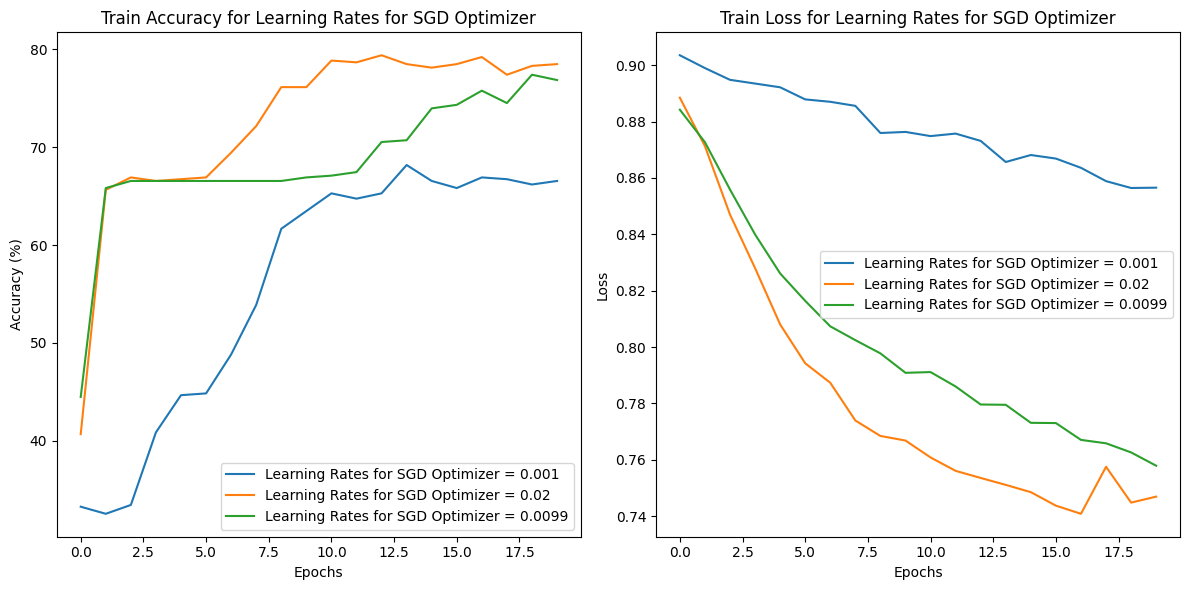

In [39]:
plot_training_progress(dropout_statistics, 'Dropout', dropout_configs)
plot_training_progress(hidden_layer_size_statistics, 'Hidden Layer Size', hidden_layer_size_configs)
plot_training_progress(learning_rate_statistics, 'Learning Rates for SGD Optimizer', learning_rates)

#### 3. After completing Step 2, choose a model with tuned hyperparameters that returns the best test accuracy and use it as a ‘base’ model.

In [40]:
# Method to find best model based on the test accuracy 
def get_best_model(results):

    # Identifying hyperparameters of model with highest accuracy
    best_config = max(results.items(), key=lambda x: x[1]['accuracy'])
    best_model = best_config[1]['model']
    
    print("\nBest Model Configuration:")
    print(f"Model Type: {best_config[1]['type']}")
    print(f"Value: {best_config[1]['value']}")
    print(f"Accuracy: {best_config[1]['accuracy']:.2f}%")
    
    return best_model

In [41]:
# Find the best model
base_model = get_best_model(test_results)


Best Model Configuration:
Model Type: learning_rate
Value: 0.0099
Accuracy: 77.39%


#### 4. Further improve your model. There are a few methods which can help increase the training speed, accuracy, etc. Find and try at least four different methods (e.g. earlystopping, k-fold, learning rate scheduler, batch normalization, data augmentation, gradient accumulation, more details on performance tuning)
<ol type='a'>
    <li>Choose a method that can improve the performance of the model. Add it to your ‘base model, finalized in Step 3.</li>
    <li>Train the model with a new method. Provide a graph that compares test accuracy for a ‘base’ model and an improved version. You can also provide a comparison w.r.t training time and other parameters.</li>
    <li>Go to Step 4a. Try four various methods or tools that aim to improve the performance of your model.</li>
    <li>After you explore various methods, finalize your NN model that returns the best results, named as ‘best model’.</li>
</ol>

In [42]:
# Defining Neural network model with batch normalization
class NNModel_BatchNormalization(nn.Module):
    def __init__(self, hidden_size=64, dropout_rate=0.5):
        super(NNModel_BatchNormalization, self).__init__()
        self.fc1 = nn.Linear(5, hidden_size)
        # 1st Batch Normalization layer
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # 2nd Batch Normalization layer
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [43]:
# Training with K-Fold Cross Validation
from sklearn.model_selection import KFold

def tain_nn_model_with_kfold(nn_model_type, k=5):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_scaled)):
        
        # Splititting data for kfold
        X_train_fold = X_scaled[train_idx]
        y_train_fold = y.iloc[train_idx]
        X_val_fold = X_scaled[val_idx]
        y_val_fold = y.iloc[val_idx]
        
        X_train_tensor = torch.FloatTensor(X_train_fold)
        y_train_tensor = torch.FloatTensor(y_train_fold.values).unsqueeze(1)
        X_val_tensor = torch.FloatTensor(X_val_fold)
        y_val_tensor = torch.FloatTensor(y_val_fold.values).unsqueeze(1)
        
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32)
        
        nn_model = nn_model_type()
        optimizer = optim.SGD(nn_model.parameters(), lr=0.01, momentum=0.9)
        
        # Model training
        model_statistics = train_model(nn_model, optimizer, train_loader, val_loader)
        
        # Evaluate model on validation data
        loss_function = nn.BCEWithLogitsLoss(pos_weight=weights[1])
        val_loss, val_acc = evaluate_model(nn_model, val_loader, loss_function)
        fold_results.append(val_acc)
    
    return np.mean(fold_results), np.std(fold_results)

In [44]:
# Train model using gradient accumulation
def train_with_gradient_accumulation(nn_model, optimizer, train_loader, accumulation_steps=4):
    nn_model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    optimizer.zero_grad()
    loss_function = nn.BCEWithLogitsLoss(pos_weight=weights[1])
    
    for idx, (data, targets) in enumerate(train_loader):
        outputs = nn_model(data)
        
        # Calculate loss
        loss = loss_function(outputs, targets)
        loss = loss / accumulation_steps
        loss.backward()
        
        if (idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        predictions = torch.round(outputs)
        
        # Update accuracy
        correct_predictions += (predictions == targets).sum().item()
        total_samples += targets.size(0)
        
        # Accumulate loss
        total_loss += loss.item() * accumulation_steps
    
    # Calculate average loss and accuracy
    average_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples
    
    return average_loss, accuracy

In [45]:
from ignite.handlers import EarlyStopping
from ignite.engine import Engine, Events
from ignite.metrics import Average
import time
import copy

c:\Users\SWETA\AppData\Local\Programs\Python\Python312\Lib\site-packages\ignite\handlers\checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [46]:
# Method for comparing models
def compare_models(base_model):
    results = {}
    training_times = {}
    
    # Base Model i.e. our reference
    print("\nBase Model:")
    start_time = time.time()
    base_model_new = copy.deepcopy(base_model)
    optimizer = optim.SGD(base_model_new.parameters(), lr=0.01, momentum=0.9)
    base_history = train_model(base_model_new, optimizer, train_data_loader, val_data_loader)
    # base_accuracy = evaluate_model(base_model, test_data_loader, nn.BCEWithLogitsLoss(pos_weight=weights[1]))[1]
    base_accuracy = test_accuracy(base_model)
    training_times['Base Model'] = time.time() - start_time
    results['Base Model'] = base_accuracy
    # print(f"Accuracy: {base_accuracy:.2f}%")
    
    # Early Stopping model
    print("\nEarly Stopping:")
    start_time = time.time()
    early_stopping_model = copy.deepcopy(base_model)
    optimizer = optim.SGD(early_stopping_model.parameters(), lr=0.01, momentum=0.9)
    loss_function = nn.BCEWithLogitsLoss(pos_weight=weights[1])
    
    def train_step(engine, batch):
        early_stopping_model.train()
        optimizer.zero_grad()
        x, y = batch
        y_pred = early_stopping_model(x)
        loss = loss_function(y_pred, y)
        loss.backward()
        optimizer.step()
        return {'loss': loss.item()}
        
    def validation_step(engine, batch):
        early_stopping_model.eval()
        with torch.no_grad():
            x, y = batch
            y_pred = early_stopping_model(x)
            loss = loss_function(y_pred, y)
            return {'loss': loss.item()}
            
    trainer = Engine(train_step)
    evaluator = Engine(validation_step)
    
    # Calculating loss on validation data 
    val_loss = Average(output_transform=lambda x: x['loss'])
    val_loss.attach(evaluator, 'loss')
    
    early_stopping = EarlyStopping(patience=5, score_function=lambda engine: -engine.state.metrics['loss'],trainer=trainer)
    evaluator.add_event_handler(Events.COMPLETED, early_stopping)
    
    # Training with early stopping
    for epoch in range(30):
        trainer.run(train_data_loader, 1)
        evaluator.run(val_data_loader)
                
        if trainer.should_terminate:
            print(f"Early stopping triggered at epoch {epoch}")
            break
    
    # es_accuracy = evaluate_model(early_stopping_model, test_data_loader, loss_function)[1]
    es_accuracy = test_accuracy(early_stopping_model)
    training_times['Early Stopping'] = time.time() - start_time
    results['Early Stopping'] = es_accuracy
    # print(f"Accuracy: {es_accuracy:.2f}%")
    
    # Model with Batch Normalization
    print("\nBatch Normalization:")
    start_time = time.time()
    bn_model = NNModel_BatchNormalization()
    optimizer = optim.SGD(bn_model.parameters(), lr=0.01, momentum=0.9)
    bn_history = train_model(bn_model, optimizer, train_data_loader, val_data_loader)
    # bn_accuracy = evaluate_model(bn_model, test_data_loader, nn.BCEWithLogitsLoss(pos_weight=weights[1]))[1]
    bn_accuracy = test_accuracy(bn_model)
    training_times['Batch Normalization'] = time.time() - start_time
    results['Batch Normalization'] = bn_accuracy
    # print(f"Accuracy: {bn_accuracy:.2f}%")
    
    # K-Fold Cross Validation
    print("\nK-Fold Cross Validation:")
    start_time = time.time()
    kfold_acc_mean, kfold_acc_std = tain_nn_model_with_kfold(NNBinaryClassification_Dropout)
    training_times['K-Fold'] = time.time() - start_time
    results['K-Fold'] = kfold_acc_mean
    print(f"Test Accuracy: {kfold_acc_mean:.2f}%")

    # Gradient Accumulation
    print("\nGradient Accumulation:")
    start_time = time.time()
    gradient_accumulation_model = copy.deepcopy(base_model)
    optimizer = optim.SGD(gradient_accumulation_model.parameters(), lr=0.01, momentum=0.9)
    gradient_accumulation_loss, gradient_accumulation_accuracy, = train_with_gradient_accumulation(gradient_accumulation_model, optimizer, train_data_loader)
    training_times['Gradient Accumulation'] = time.time() - start_time
    results['Gradient Accumulation'] = gradient_accumulation_accuracy * 100
    print(f"Test Accuracy: {gradient_accumulation_accuracy* 100:.2f}%")
    
    return results, training_times

In [47]:
results, training_times = compare_models(base_model)


Base Model:
Test Accuracy: 77.39%

Early Stopping:
Test Accuracy: 73.04%

Batch Normalization:
Test Accuracy: 74.78%

K-Fold Cross Validation:
Test Accuracy: 76.37%

Gradient Accumulation:
Test Accuracy: 78.66%


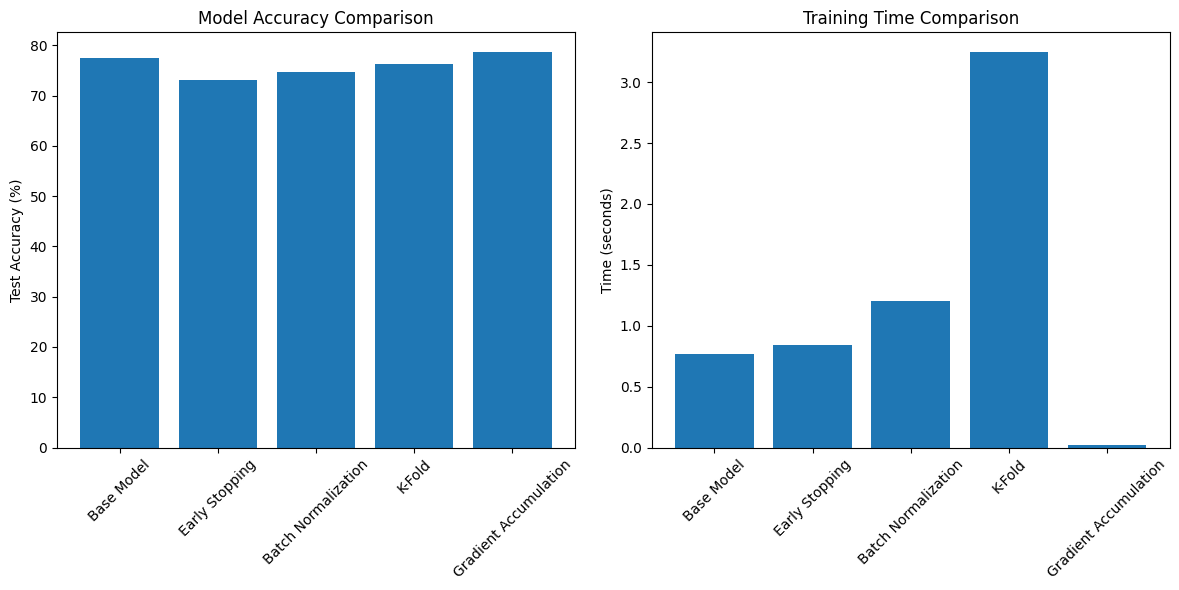

In [48]:
# Plot accuracy and training time for all the training methods
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(results.keys(), results.values())
plt.title('Model Accuracy Comparison')
plt.ylabel('Test Accuracy (%)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(training_times.keys(), training_times.values())
plt.title('Training Time Comparison')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [49]:
# Identify best model
best_method = max(results.items(), key=lambda x: x[1])[0]
print(f"\nBest performing method: {best_method}")
print(f"Best accuracy: {results[best_method]:.2f}%")
print(f"Training time: {training_times[best_method]:.2f} seconds")


Best performing method: Gradient Accumulation
Best accuracy: 78.66%
Training time: 0.02 seconds


#### 5. For your ‘best model’ defined in Step 4:
<ol type='a'>
    <li>Save the weights of the trained neural network (Part I, Step 5)</li>
    <li>Evaluate the performance of the model on the testing data (Part I, Step 6)</li>
    <li>Visualize the results (Part I, Step 7)</li>
</ol>

In [ ]:
# Save best model
if best_method == "Batch Normalization":
    best_model = NNModel_BatchNormalization()
else:
    best_model = copy.deepcopy(base_model)
    
torch.save(best_model.state_dict(), 'swetasah_assignment2_part_2.pth')

In [51]:
# Evaluate performance on test data
from sklearn.metrics import precision_recall_fscore_support
from torchmetrics import Accuracy

# Initialize empty lists for true and predicted values
y_true = []
y_pred = []
# Initialize accuracy for binary classification
accuracy_metric = Accuracy(task='binary')
loss_function = nn.BCEWithLogitsLoss(pos_weight=weights[1])

test_running_loss = 0.0

best_model.eval()

with torch.no_grad(): 
    for inputs, labels in test_data_loader:
        outputs = best_model(inputs)

        loss = loss_function(outputs, labels.view(-1, 1))

        # Calculate test loss
        test_running_loss += loss.item()

        predicted = torch.round(outputs)

        accuracy_metric.update(predicted, labels.view(-1, 1))

        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())


# Calculate accuracy
test_accuracy = accuracy_metric.compute().item()
print(f'Test Accuracy: {test_accuracy* 100:.2f}%')

test_loss = test_running_loss / len(test_data_loader)

# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}')

Test Accuracy: 77.39%
Precision: 0.7273, Recall: 0.5854, F1 Score: 0.6486


In [52]:
# Train best model to get the train and validation accuracies and losses
def train_model(nn_model, optimizer, train_loader, val_loader, num_epochs=20):
    criterion = nn.BCEWithLogitsLoss(pos_weight=weights[1])
    best_model_metrices = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    accuracy_metric = Accuracy(task='binary')
    
    for epoch in range(num_epochs):
        nn_model.train()
        train_running_loss = 0.0
        accuracy_metric.reset()
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = nn_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_running_loss += loss.item()
            predicted = torch.round(outputs)
            accuracy_metric.update(predicted, labels)
            
        # Calculate training loss and accuracy
        train_loss = train_running_loss / len(train_loader)
        train_acc = accuracy_metric.compute().item()
        
        nn_model.eval()
        val_running_loss = 0.0
        accuracy_metric.reset()
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = nn_model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                
                predicted = torch.round(outputs)
                accuracy_metric.update(predicted, labels)
                
        # Calculate validation loss and accuracy
        val_loss = val_running_loss / len(val_loader)
        val_acc = accuracy_metric.compute().item()
        
        best_model_metrices['train_loss'].append(train_loss)
        best_model_metrices['train_acc'].append(train_acc)
        best_model_metrices['val_loss'].append(val_loss)
        best_model_metrices['val_acc'].append(val_acc)
    
    return best_model_metrices

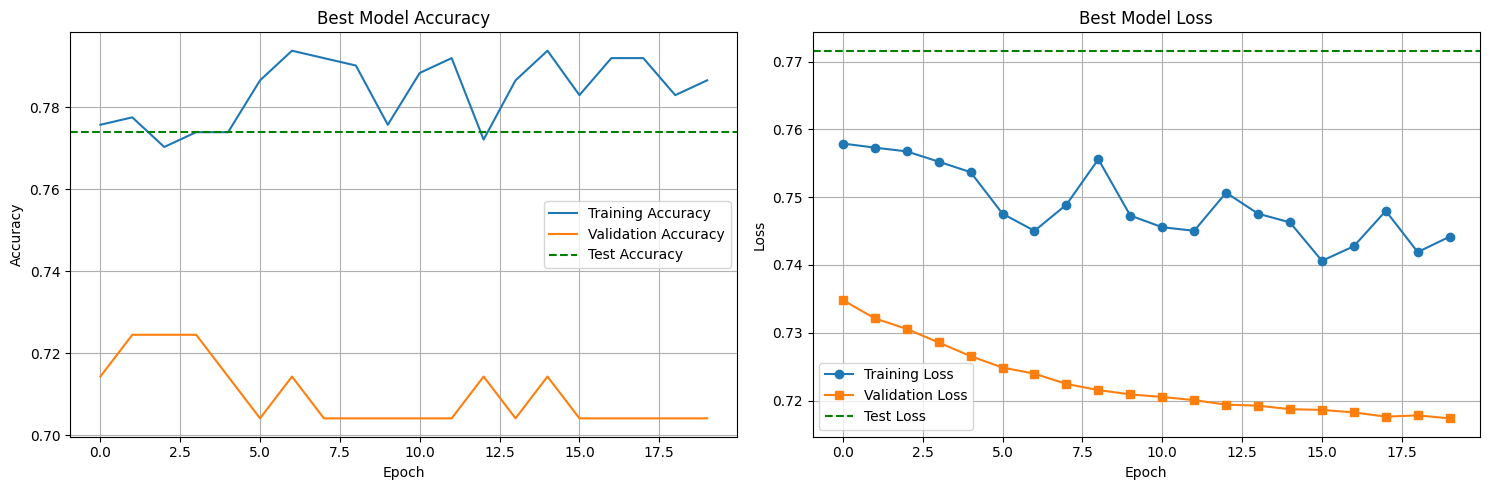

In [53]:
optimizer = optim.SGD(best_model.parameters(), lr=0.01, momentum=0.9)
best_model_metric = train_model(best_model, optimizer, train_data_loader, val_data_loader)

# Plot accracy and loss for best model
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(best_model_metric['train_acc'], label='Training Accuracy')
plt.plot(best_model_metric['val_acc'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='g', linestyle='--', label='Test Accuracy')
plt.title('Best Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(best_model_metric['train_loss'], label='Training Loss', marker='o')
plt.plot(best_model_metric['val_loss'], label='Validation Loss', marker='s')
plt.axhline(y=test_loss, color='g', linestyle='--', label='Test Loss')
plt.title('Best Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

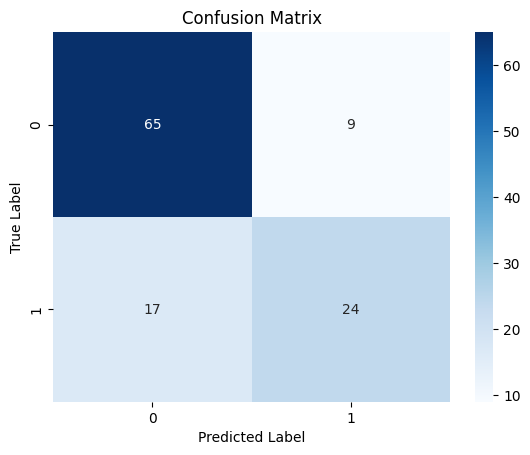

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true_np = np.array(y_true)
y_pred_np = np.array(y_pred)

cm = confusion_matrix(y_true_np, y_pred_np)

# Plot confusion matrix
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

C:\Users\SWETA\AppData\Local\Temp\ipykernel_16444\2594080749.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  y_pred = torch.tensor(y_pred).squeeze()


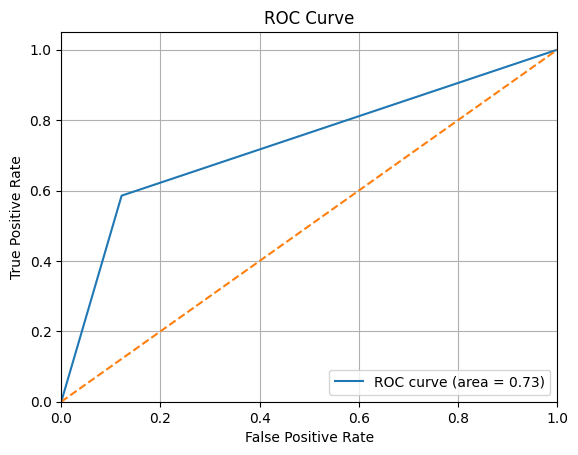

In [55]:
# Plot ROC curve
from torchmetrics import ROC, AUROC

y_pred = torch.tensor(y_pred).squeeze()
y_true = np.array(y_true, dtype=np.int64)
y_true = torch.tensor(y_true, dtype=torch.long).squeeze()

roc = ROC(task='binary')
auroc = AUROC(task='binary')

# Calculate FPR, TPR, and thresholds for ROC curve
fpr, tpr, thresholds = roc(y_pred, y_true)

# Calculate AUROC score
roc_auc = auroc(y_pred, y_true)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### References

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
# https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
# https://kozodoi.me/blog/20210219/gradient-accumulation